Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [15]:
from random import random, seed
from itertools import product
import numpy as np
from itertools import accumulate
from icecream import ic

from matplotlib import pyplot as plt
from copy import copy
from tqdm import tqdm

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [16]:
UNIVERSE_SIZE = 10000
NUM_SETS = 1000
if(UNIVERSE_SIZE<=10000):
    MAX_STEPS = 10000
else:
    MAX_STEPS = 100000 #for big cases we'll need more steps
DENSITY = .2

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10000 * DENSITY)]))

In [17]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [18]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def single_mutation(solution: np.ndarray)-> np.ndarray:
    new_solution = solution.copy()
    i=rng.integers(0,NUM_SETS)
    new_solution[i]=not new_solution[i]
    return new_solution

def multiple_mutation_mask(solution :np.ndarray) -> np.ndarray:
    mask= rng.random(NUM_SETS)<0.01 #creating random mask
    new_solution = np.logical_xor(solution,mask) #xor operation
    return new_solution

#We do multiple mutation at once (i found better results with this instead of the mask used in class)
def multiple_mutation(solution :np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index = np.random.randint(0, NUM_SETS)
        new_solution[index] = not new_solution[index]
    return new_solution

#only checks if the solution is valid
def fitness_valid(solution :np.ndarray):
    return (valid(solution),-cost(solution))

#checks how many of the items are covered
def fitness_covered(solution: np.ndarray) -> tuple:
    selected_sets = SETS[solution]  
    covered_items = np.sum(np.any(selected_sets, axis=0))  
    return (covered_items, -cost(solution)) 

#weigths the items based on its rarity (1/frequency)
item_frequencies = np.sum(SETS, axis=0)
rarity_weights = 1 / (item_frequencies + 1e-9)  

def fitness_rarity(solution: np.ndarray) -> tuple:
    selected_sets = SETS[solution]  
    covered_items = np.any(selected_sets, axis=0)  
    rarity_score = np.sum(covered_items * rarity_weights)  
    return (rarity_score, -cost(solution))  

## Have Fun!

In [19]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(4275656.3524170015))

In [20]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(2137834.814063535))

I worked with Giorgio Rondinone and Simone Scalora
## Best Solution Found : Steepest step + Restart + Multiple mutation + Rarity

This algorithm uses a fitness function that exploits rarity of each item in order to prioritize rarer items. We also implement a steepest step with restarts based on the size of the parameters.  

This allows us to get a better solution by trying multiple times for smaller problems but in case of large problems(100000 universe size) we do not implement the restart mechanism as the size of this problem makes it a very time consuming to execute.  

There's also a cap for the number of steps without any improvement, so that we can compute the iteration it took to find a (supposedly) optimal solution.  

Please take note that for the problems with universe size == 100000 the algorithm takes quite some time.  

We also start from a randomized starting solution

In the rest of the document there are various algorithms which i tried and confronted in order to get to this conclusion.

 22%|██▏       | 2191/9999 [00:06<00:23, 332.07it/s] 
ic| valid(solution): np.True_
    cost(solution): np.float64(129910.39006038959)


Terminating at iteration 2192 due to no improvement.


 38%|███▊      | 3764/9999 [00:08<00:13, 457.05it/s] 
ic| valid(solution): np.True_
    cost(solution): np.float64(117434.3276924251)


Terminating at iteration 3765 due to no improvement.


 33%|███▎      | 3256/9999 [00:09<00:19, 337.99it/s] 
ic| valid(solution): np.True_
    cost(solution): np.float64(123018.93050142647)
ic| valid(best_solution): np.True_
    cost(best_solution): np.float64(117434.3276924251)


Terminating at iteration 3257 due to no improvement.

Best solution: 117434.3276924251 found at (2, 2237) -- total steps: 46070


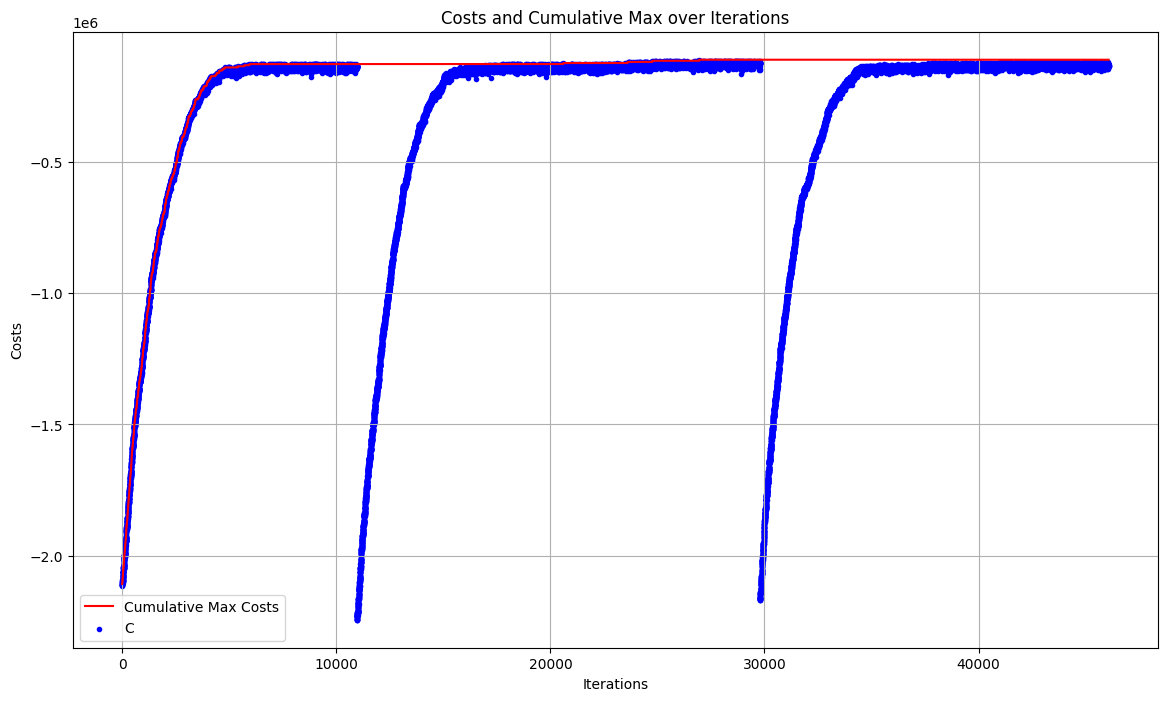

In [21]:
if UNIVERSE_SIZE >50000:
    NUM_RESTARTS = 1 #no restarts because of long execution time
    STEEPEST_STEP_CANDIDATES = 3
    MAX_NO_IMPROVEMENT = 2000
else:
    NUM_RESTARTS = 3 #restarting for trying a better solution
    STEEPEST_STEP_CANDIDATES = 5 #more candidates
    MAX_NO_IMPROVEMENT = (MAX_STEPS/10)+20 #please note that this value is a compromise between having less iteration but not always a "real" optimum. If we increase this number we'll have slightly better solutions with lots of unnecessary iterations

max_value = float('inf')
num_steps = 0
history = list()
best_solution = None
tweak=multiple_mutation
for i in range(0, NUM_RESTARTS): #restart loop
    solution = np.random.rand(NUM_SETS) < 0.5  #randomized starting solution each loop
    history.append(fitness_rarity(solution)) #saving fitness for plot

    last_improvement = (0, 0) #last improvement for the iterations used
    new_solution = solution
    no_improvement_count = 0  

    for n in tqdm(range(1, MAX_STEPS), position=1): #steepest step
        candidates = [tweak(solution) for _ in range(STEEPEST_STEP_CANDIDATES)]
        candidates_fitness = []
        for c in candidates:
            f = fitness_rarity(c)
            history.append(f)
            candidates_fitness.append(f)
        
        idx = candidates_fitness.index(max(candidates_fitness)) #after trying each candidate find the best

        new_solution = candidates[idx]
        new_fitness = candidates_fitness[idx]
        num_steps += STEEPEST_STEP_CANDIDATES

        if new_fitness > fitness_rarity(solution): #check if new solution is better
            last_improvement = (i, n) #note this improvement
            solution = new_solution # we have a new solution
            solution_steps=num_steps # save the iteration number
            no_improvement_count = 0  #reset no improv counter
        else:
            no_improvement_count += 1 # this iteration doesn't have an improvement

        
        if no_improvement_count >= MAX_NO_IMPROVEMENT:
            print(f"Terminating at iteration {n} due to no improvement.")
            break

    
    #current_fitness = fitness_rarity(solution)
    current_cost = cost(solution) 

    if current_cost < max_value:  # Select best solution among all restarts
        max_value = current_cost
        best_solution = solution    # Change best solution
    ic(valid(solution), cost(solution))

ic(valid(best_solution), cost(best_solution))
print(f"\nBest solution: {cost(best_solution)} found at {last_improvement} -- total steps: {num_steps}")


rarity_scores = [fit[0] for fit in history] # not used but useful if we want to plot rarity scores (don't think that's relevant)
costs = [fit[1] for fit in history]  #select costs from fitness history

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(costs)),
    list(accumulate(costs, max)),  
    color="red",
    label='Cumulative Max Costs'
)
plt.scatter(range(len(costs)), costs, marker=".", color='blue', label='C')
plt.title("Costs and Cumulative Max over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Costs")
plt.legend()
plt.grid()
plt.show()




All of the algorithms below are not part of the solution

## Simple Hillclimbing with Single Mutation (Solution set to all true)

ic| fitness_valid(solution): (np.True_, np.float64(-4275656.3524170015))
100%|██████████| 10000/10000 [00:15<00:00, 660.50it/s]
ic| valid(solution): np.True_
    cost(solution): np.float64(123346.37387383086)


(np.True_, np.float64(123346.37387383086))

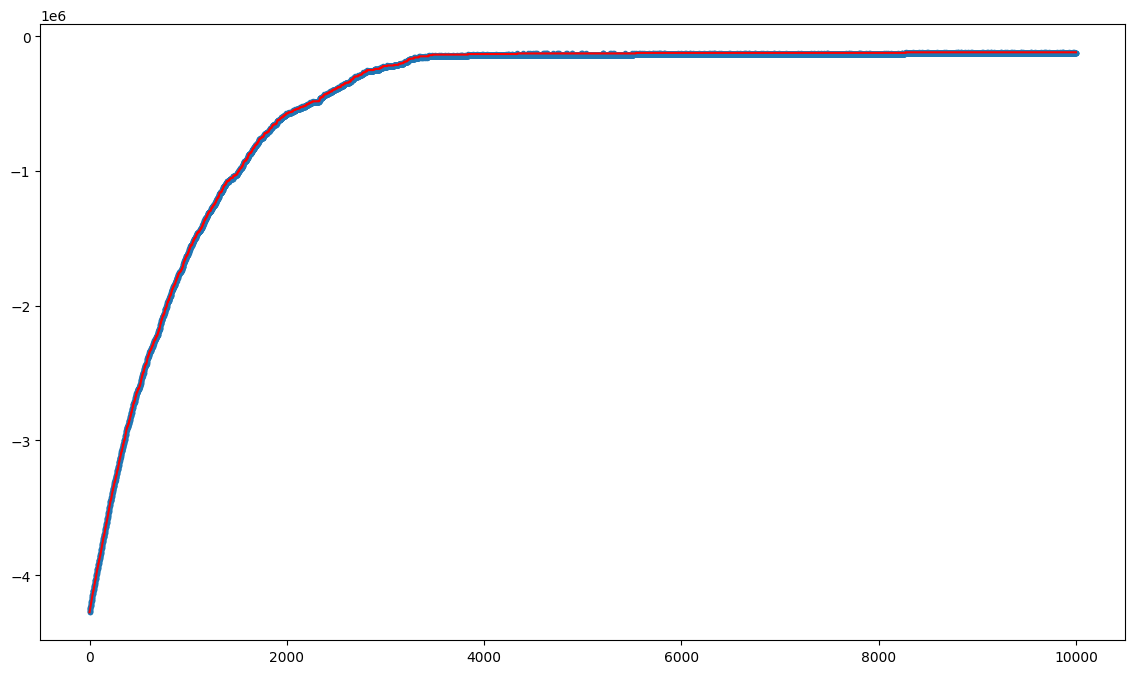

In [28]:

    


def single_mutation(solution: np.ndarray)-> np.ndarray:
    new_solution = solution.copy()
    i=rng.integers(0,NUM_SETS)
    new_solution[i]=not new_solution[i]
    return new_solution




# ic(fitness(solution))
#solution = np.full(NUM_SETS, True)
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness_valid(solution)
history = [float(solution_fitness[1])]
ic(fitness_valid(solution))
tweak=single_mutation
#tweak=multiple_mutation

for n in tqdm(range(MAX_STEPS)):
    new_solution = tweak(solution)
    f=fitness_valid(new_solution)
    
    history.append(float(f[1]))
    if f > solution_fitness:
        solution = new_solution  
        solution_fitness=fitness_valid(solution)
    
    #history.append(fitness(solution))
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
#ic(solution)
ic(valid(solution), cost(solution))


## Multiple mutation HillClimb

ic| fitness_valid(solution): (np.True_, np.float64(-4275656.3524170015))
100%|██████████| 10000/10000 [00:11<00:00, 884.23it/s]
ic| valid(solution): np.True_
    cost(solution): np.float64(134743.8637631781)


(np.True_, np.float64(134743.8637631781))

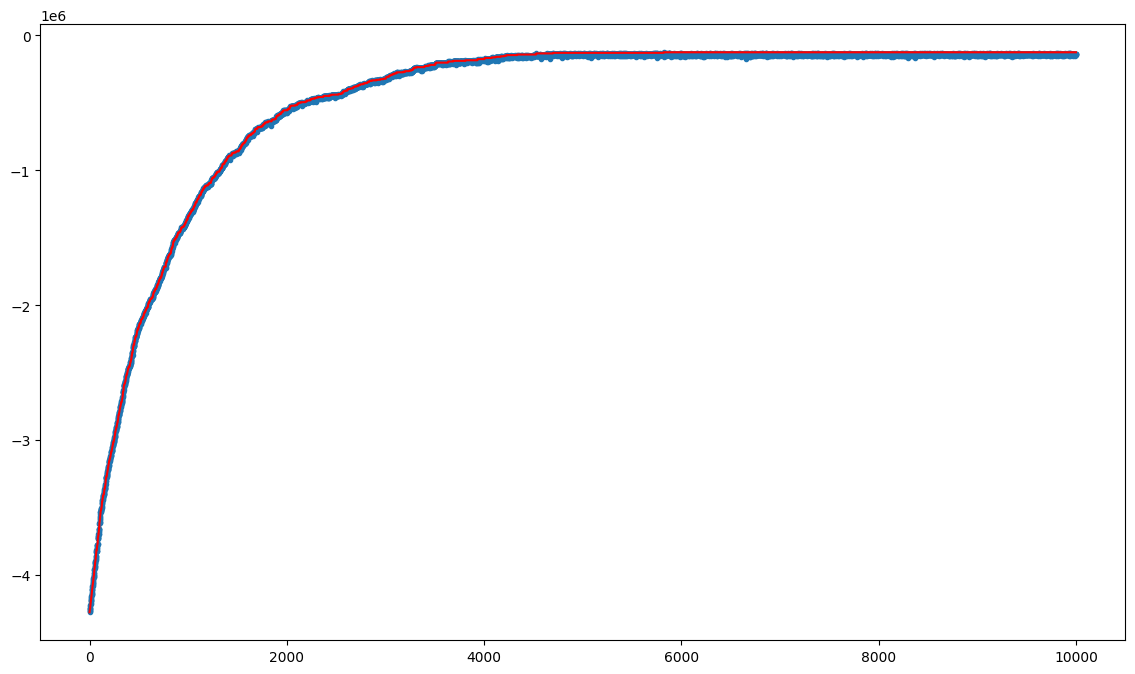

In [23]:

# If we randomize the solution, it won't work for smaller values (harder to get a starting valid solution), so we'll leave a full true solution for now.
# The next algorithm solves this issue
solution = rng.random(NUM_SETS) < 1 

solution_fitness = fitness_valid(solution)
history = [float(solution_fitness[1])]
ic(fitness_valid(solution))
tweak=multiple_mutation

for n in tqdm(range(MAX_STEPS)):
    new_solution = tweak(solution)
    f=fitness_valid(new_solution)
    
    history.append(float(f[1]))
    if f > solution_fitness:
        solution = new_solution  
        solution_fitness=fitness_valid(solution)
    
    #history.append(fitness(solution))
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
#ic(solution)
ic(valid(solution), cost(solution))


## Multiple Mutation checking for covered items, using a random starting point

ic| solution_fitness: (np.int64(10000), np.float64(-2117798.9251493374))
ic| fitness_covered(solution): (np.int64(10000), np.float64(-2117798.9251493374))
100%|██████████| 10000/10000 [00:03<00:00, 2568.37it/s]
ic| "finale": 'finale'
    fitness_covered(solution): (np.int64(10000), np.float64(-134503.50273922412))
ic| valid(solution): np.True_
    cost(solution): np.float64(134503.50273922412)


(np.True_, np.float64(134503.50273922412))

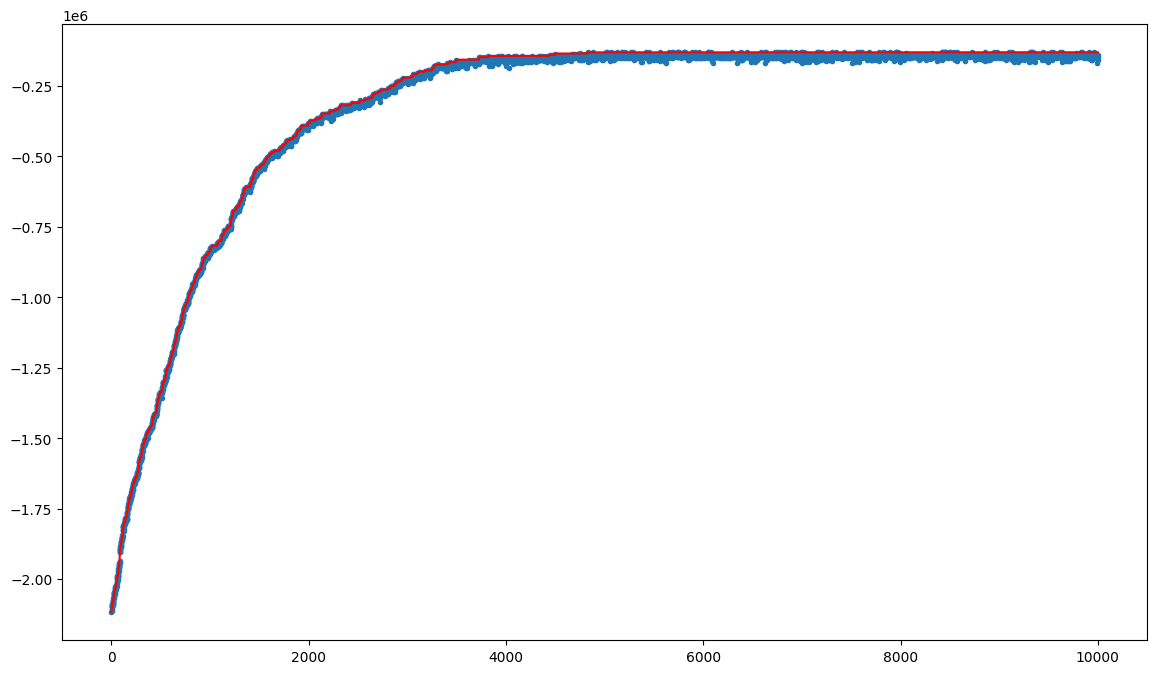

In [24]:

solution = rng.random(NUM_SETS) < 0.5
selected_sets = SETS[solution]
solution_fitness = fitness_covered(solution)
ic(solution_fitness)
history = [float(solution_fitness[1])]
ic(fitness_covered(solution))
tweak = multiple_mutation


for n in tqdm(range(MAX_STEPS)):
    new_solution = tweak(solution)
    f = fitness_covered(new_solution)
    
    history.append(float(f[1]))  
    if f > solution_fitness:  
        solution = new_solution  
        solution_fitness = f  
        
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
# Verifica finale
ic("finale",fitness_covered(solution))
ic(valid(solution), cost(solution))

#(np.True_, np.float64(108512897.97921969))


## Rarity-based Multiple Mutation HC

ic| solution_fitness: (np.float64(50.209891246796545), np.float64(-2094499.0170750667))
ic| fitness_rarity(solution): (np.float64(50.209891246796545), np.float64(-2094499.0170750667))
100%|██████████| 10000/10000 [00:03<00:00, 2873.25it/s]
ic| "finale": 'finale'
    solution_fitness: (np.float64(50.209891246796545), np.float64(-134333.05462457094))
ic| valid(solution): np.True_
    cost(solution): np.float64(134333.05462457094)


(np.True_, np.float64(134333.05462457094))

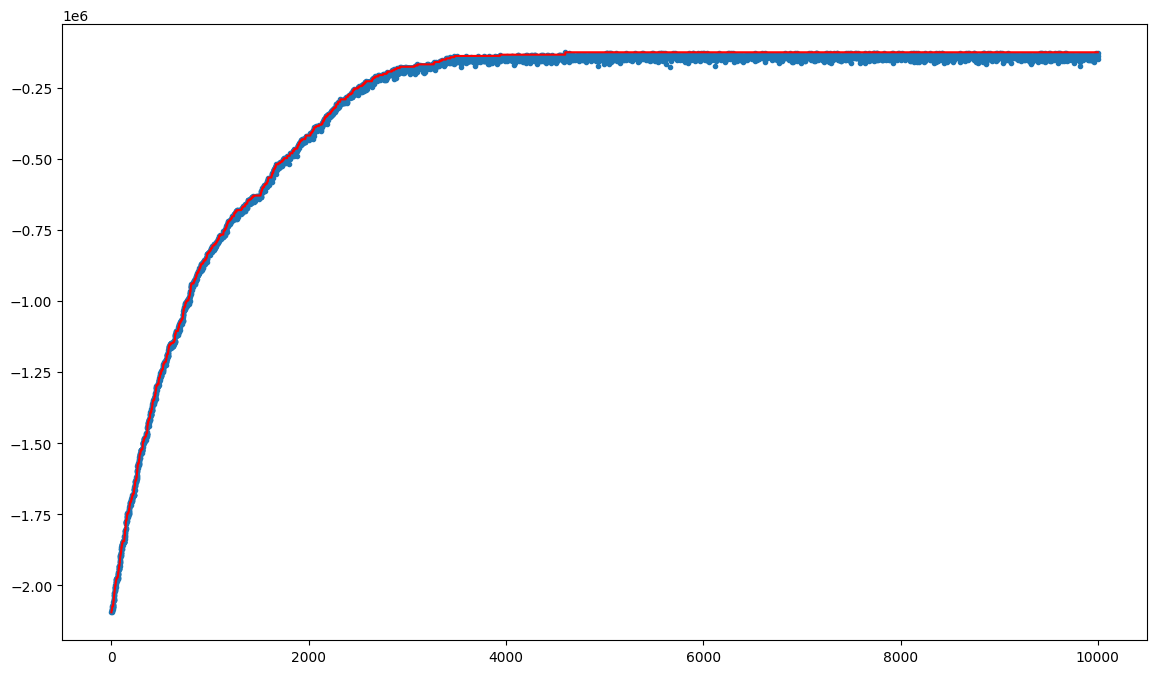

In [25]:

solution = rng.random(NUM_SETS) < 0.5
selected_sets = SETS[solution]
solution_fitness = fitness_rarity(solution)
ic(solution_fitness)
history = [float(solution_fitness[1])]
ic(fitness_rarity(solution))
tweak = multiple_mutation

for n in tqdm(range(MAX_STEPS)):
    new_solution = tweak(solution)  
    f = fitness_rarity(new_solution) 
    
    history.append(float(f[1])) 
    if f > solution_fitness:  
        solution = new_solution
        solution_fitness = f  

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


ic("finale", solution_fitness)
ic(valid(solution), cost(solution))

## Tabu Search

100%|██████████| 10000/10000 [00:08<00:00, 1140.89it/s]


Final fitness: (np.float64(50.209891246796545), np.float64(-136400.91871385713))
Final cost: 136400.91871385713
Solution valid: True


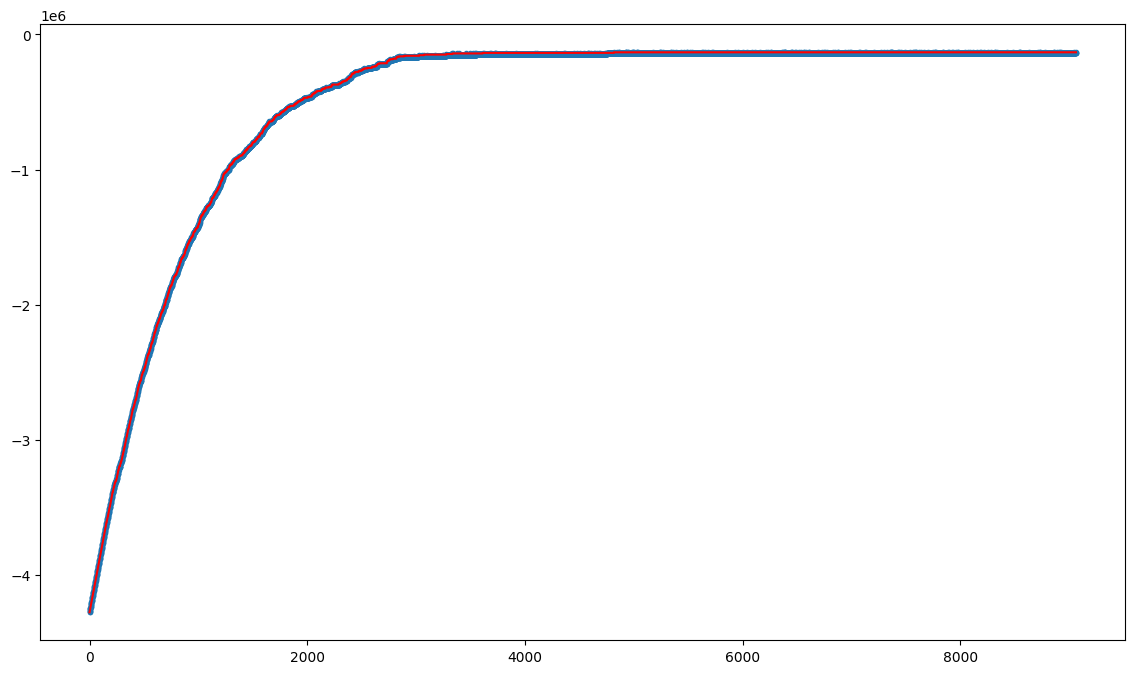

In [26]:
import numpy as np
from itertools import accumulate
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

TABU_TENURE = 100  



def single_mutation(solution: np.ndarray) -> np.ndarray:
    new_solution = solution.copy()
    i = rng.integers(0, NUM_SETS)
    new_solution[i] = not new_solution[i]
    return new_solution, i  


solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness_rarity(solution)

tabu_list = []
tabu_tenure = TABU_TENURE

history = [float(solution_fitness[1])]

for step in tqdm(range(MAX_STEPS)):
    new_solution, mutated_index = single_mutation(solution)
    
    if mutated_index in tabu_list and fitness_rarity(new_solution) <= solution_fitness:
        continue

    new_fitness = fitness_rarity(new_solution)
    
    history.append(float(new_fitness[1]))

    if new_fitness > solution_fitness:
        solution = new_solution
        solution_fitness = new_fitness

        tabu_list.append(mutated_index)

        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),  
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

print("Final fitness:", solution_fitness)
print("Final cost:", cost(solution))
print("Solution valid:", valid(solution))


## Simulated annealing

In [27]:

import math



def accept_solution(delta_fitness: float, delta_cost: float, temperature: float) -> bool:
    if delta_fitness > 0 or (delta_fitness == 0 and delta_cost > 0):
        return True
    
    max_exp_value = 700  # Limite per math.exp (valori troppo alti causano overflow)
    min_exp_value = -700  # Limite inferiore per evitare underflow

    exp_value = delta_fitness + delta_cost / temperature
    # Clamping: limitiamo il valore di exp_value in un range gestibile
    exp_value = min(max(exp_value, min_exp_value), max_exp_value)
    
    return rng.random() < math.exp(exp_value)


INITIAL_TEMPERATURE = 1000.0
FINAL_TEMPERATURE = 0.1
COOLING_RATE = 0.995
MAX_STEPS = 10000


def simulated_annealing():
    solution = rng.random(NUM_SETS) < 0.5  
    solution_fitness = fitness_rarity(solution)
    
    temperature = INITIAL_TEMPERATURE
    best_solution = solution.copy()
    best_fitness = solution_fitness

    history = [solution_fitness[1]]  
    
    for step in tqdm(range(MAX_STEPS)):
        new_solution = tweak(solution)
        new_fitness = fitness_rarity(new_solution)
        
        
        delta_fitness = new_fitness[0] - solution_fitness[0]  
        delta_cost = new_fitness[1] - solution_fitness[1]  
        
        if accept_solution(delta_fitness, delta_cost, temperature):
            solution = new_solution
            solution_fitness = new_fitness

            if new_fitness[0] > best_fitness[0] or (new_fitness[0] == best_fitness[0] and new_fitness[1] > best_fitness[1]):
                best_solution = new_solution.copy()
                best_fitness = new_fitness

        
        temperature = max(FINAL_TEMPERATURE, temperature * COOLING_RATE)
        
       
        history.append(float(solution_fitness[1]))

    return best_solution, best_fitness, history


best_solution, best_fitness, history = simulated_annealing()

ic(best_fitness)
ic(valid(best_solution), cost(best_solution))


100%|██████████| 10000/10000 [00:03<00:00, 2556.79it/s]
ic| best_fitness: (np.float64(50.209891246796545), np.float64(-152442.1069615036))
ic| valid(best_solution): np.True_
    cost(best_solution): np.float64(152442.1069615036)


(np.True_, np.float64(152442.1069615036))